In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder, StandardScaler

##### 该修改证实id先转独热编码然后嵌入配合回归模型测试的MSE对wide&deep模型没有提升反而会导致变差，和GPT的解释一致，即提高稀疏程度然后下降有害，解释了嵌入/MLP/回归组合在这个任务中的局限性 但是调整学习率发现wide&deep本身还是很强大的，和之前的测试不同，可以达到SOTA水平，揭示了调参的重要性

In [7]:
#如果对id使用独热编码转换然后嵌入会导致变差
#结论1：对id独热然后嵌入看不出什么好处，对特征嵌入反而导致学习能力变差了
# 读取数据
data1 = pd.read_csv('data1.csv')
data1.drop(data1.columns[0], axis=1, inplace=True)

# 提取目标变量和特征
y = data1['rating']
X = data1.drop(columns=['rating'])

# 连续特征标准化
continuous_cols = ['release_date', 'age', 'timestamp']
scaler = StandardScaler()
X[continuous_cols] = scaler.fit_transform(X[continuous_cols])

# 低维分类特征保留
simple_cols = ['gender', 'zip code', 'occupation']

# 独热编码离散特征
idcolumns = ['user id', 'item id']
encoder = OneHotEncoder()
encoded_cats = encoder.fit_transform(X[idcolumns]).toarray()  # 转换为密集矩阵

# 将独热编码后的特征转成 DataFrame，并转换为 int 类型
encoded_cats_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(idcolumns)).astype(int)

# 删除原始的离散特征，并将独热编码的特征拼接回原数据框
X = X.drop(columns=idcolumns)
X = pd.concat([X, encoded_cats_df], axis=1)

# 多热编码标签信息
label_cols = [col for col in X.columns if col not in continuous_cols + simple_cols + encoder.get_feature_names_out(idcolumns).tolist()]
X_labels = X[label_cols]
X_labels = X_labels.values

# 删除标签列，剩下的是 continuous_cols 和 simple_cols
X = X.drop(columns=label_cols)

# 创建数据集类
class MovieRatingDataset(Dataset):
    def __init__(self, X_low, X_onehot, X_labels, X_cont, y):
        self.X_low = torch.tensor(X_low.values, dtype=torch.float32)
        self.X_onehot = torch.tensor(X_onehot.values, dtype=torch.long)
        self.X_labels = torch.tensor(X_labels, dtype=torch.long)
        self.X_cont = torch.tensor(X_cont.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_low[idx], self.X_onehot[idx], self.X_labels[idx], self.X_cont[idx], self.y[idx]

# 数据集实例化
dataset = MovieRatingDataset(X[simple_cols], X[encoder.get_feature_names_out(idcolumns)], X_labels, X[continuous_cols], y)

# 数据加载器
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 模型定义
class WideAndDeepModel(nn.Module):
    def __init__(self, user_input_dim, item_input_dim, label_input_dim, embedding_dim, num_cont_features, num_low_dim_features):
        super(WideAndDeepModel, self).__init__()
        self.user_embedding = nn.Embedding(user_input_dim, embedding_dim)
        self.item_embedding = nn.Embedding(item_input_dim, embedding_dim)
        self.label_embedding = nn.Embedding(label_input_dim, 3)
        self.deep = nn.Sequential(
            nn.Linear(embedding_dim * 2 + 3* label_input_dim + num_cont_features + num_low_dim_features, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.wide = nn.Linear(embedding_dim * 2 + 3 * label_input_dim + num_cont_features + num_low_dim_features, 1)

    def forward(self, x_low, x_onehot, x_labels, x_cont):
        user_emb = self.user_embedding(x_onehot[:, 0])
        item_emb = self.item_embedding(x_onehot[:, 1])
        label_emb = self.label_embedding(x_labels).view(x_labels.size(0), -1)
        x_emb = torch.cat([user_emb, item_emb, label_emb], dim=1)
        x = torch.cat([x_emb, x_low, x_cont], dim=1)
        deep_out = self.deep(x)
        wide_out = self.wide(x)
        return wide_out + deep_out

# 获取 user_id 和 item_id 的类别数量
user_input_dim = data1['user id'].nunique()
item_input_dim = data1['item id'].nunique()
label_input_dim = X_labels.shape[1]
embedding_dim = 4
num_cont_features = len(continuous_cols)
num_low_dim_features = len(simple_cols)

model = WideAndDeepModel(user_input_dim, item_input_dim, label_input_dim, embedding_dim, num_cont_features, num_low_dim_features)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 训练模型
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for x_low, x_onehot, x_labels, x_cont, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(x_low, x_onehot, x_labels, x_cont).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x_low.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    if (epoch + 1) % 1 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

# 测试模型
model.eval()
y_pred = []
with torch.no_grad():
    for x_low, x_onehot, x_labels, x_cont, _ in test_loader:
        outputs = model(x_low, x_onehot, x_labels, x_cont).squeeze()
        y_pred.extend(outputs.numpy())
y_pred = np.array(y_pred)

# 计算均方误差
y_test = np.array([test_dataset[i][4].numpy() for i in range(len(test_dataset))])
mse = np.mean((y_test - y_pred) ** 2)
print(f'MSE: {mse:.4f}')
#GPT:通常不建议将独热编码后的特征再嵌入。独热编码后的维度会非常高，这样不仅会增加模型复杂度，还会导致训练困难。建议直接对用户和物品 ID 进行嵌入，而对其他分类特征，使用嵌入层来学习它们的表示。


Epoch 1/50, Loss: 1.3246
Epoch 2/50, Loss: 1.2276
Epoch 3/50, Loss: 1.2321
Epoch 4/50, Loss: 1.2190
Epoch 5/50, Loss: 1.2291
Epoch 6/50, Loss: 1.2236
Epoch 7/50, Loss: 1.2306
Epoch 8/50, Loss: 1.2183
Epoch 9/50, Loss: 1.2303
Epoch 10/50, Loss: 1.2194
Epoch 11/50, Loss: 1.2230
Epoch 12/50, Loss: 1.2288
Epoch 13/50, Loss: 1.2267
Epoch 14/50, Loss: 1.2251
Epoch 15/50, Loss: 1.2241
Epoch 16/50, Loss: 1.2239
Epoch 17/50, Loss: 1.2221
Epoch 18/50, Loss: 1.2234
Epoch 19/50, Loss: 1.2212
Epoch 20/50, Loss: 1.2235
Epoch 21/50, Loss: 1.2195
Epoch 22/50, Loss: 1.2252
Epoch 23/50, Loss: 1.2180
Epoch 24/50, Loss: 1.2218
Epoch 25/50, Loss: 1.2196
Epoch 26/50, Loss: 1.2224
Epoch 27/50, Loss: 1.2286
Epoch 28/50, Loss: 1.2194
Epoch 29/50, Loss: 1.2147
Epoch 30/50, Loss: 1.2128
Epoch 31/50, Loss: 1.2215
Epoch 32/50, Loss: 1.2202
Epoch 33/50, Loss: 1.2259
Epoch 34/50, Loss: 1.2218
Epoch 35/50, Loss: 1.2161
Epoch 36/50, Loss: 1.2192
Epoch 37/50, Loss: 1.2277
Epoch 38/50, Loss: 1.2201
Epoch 39/50, Loss: 1.

In [9]:
#Wide&Deep 0.8953 这里也用了嵌入，但是只嵌入分类特征并且分开嵌入，而且挺粗暴的，没有嵌入id，但是表现很好，说明id嵌入+独热编码存在问题（但是想直接嵌入也很难，存在前后不全面的问题，嵌入会出错）,一种处理方法是没见过的赋予同一个id，
#直接删除也可以，但是表现差了不少
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
class MovieRatingDataset(Dataset):
    def __init__(self, X_cat, X_cont, y):
        self.X_cat = torch.tensor(X_cat.values, dtype=torch.long)
        self.X_cont = torch.tensor(X_cont, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X_cat[idx], self.X_cont[idx], self.y[idx]
class WideAndDeepModel(nn.Module):
    def __init__(self, categorical_dims, embedding_dim, num_cont_features):
        super(WideAndDeepModel, self).__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(input_dim, embedding_dim) for input_dim in categorical_dims
        ])
        self.deep = nn.Sequential(
            nn.Linear(len(categorical_dims) * embedding_dim + num_cont_features, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.wide = nn.Linear(len(categorical_dims) * embedding_dim + num_cont_features, 1)
    def forward(self, x_cat, x_cont):
        x_cat = [self.embeddings[i](x_cat[:, i]) for i in range(len(self.embeddings))]
        x_cat = torch.cat(x_cat, dim=1)
        x = torch.cat([x_cat, x_cont], dim=1)
        deep_out = self.deep(x)
        wide_out = self.wide(x)
        return wide_out + deep_out
def encode_features(train_df, test_df, continuous_features):
    encoded_train_df = train_df.copy()
    encoded_test_df = test_df.copy()
    label_encoders = {}
    
    for column in train_df.columns:
        if column not in continuous_features:
            le = LabelEncoder()
            encoded_train_df[column] = le.fit_transform(train_df[column])
            encoded_test_df[column] = le.transform(test_df[column])
            label_encoders[column] = le       
    return encoded_train_df, encoded_test_df, label_encoders
y = data1['rating']
X = data1.drop(columns=['rating'])
continuous_cols = ['release_date', 'user id', 'item id']
categorical_cols = X.drop(columns=continuous_cols).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_cat, X_test_cat, label_encoders = encode_features(X_train[categorical_cols], X_test[categorical_cols], continuous_cols)
scaler = StandardScaler()
X_train_cont = scaler.fit_transform(X_train[continuous_cols])
X_test_cont = scaler.transform(X_test[continuous_cols])
train_dataset = MovieRatingDataset(X_train_cat, X_train_cont, y_train)
test_dataset = MovieRatingDataset(X_test_cat, X_test_cont, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

categorical_dims = [X_train[col].nunique() for col in categorical_cols]
model = WideAndDeepModel(categorical_dims, embedding_dim=4, num_cont_features=len(continuous_cols))

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_cat_batch, X_cont_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_cat_batch, X_cont_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_cat_batch.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    if (epoch+1)%1==0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

model.eval()
y_pred = []
with torch.no_grad():
    for X_cat_batch, X_cont_batch, _ in test_loader:
        outputs = model(X_cat_batch, X_cont_batch).squeeze()
        y_pred.extend(outputs.numpy())
y_pred = np.array(y_pred)
mse = np.mean((y_test.values - y_pred) ** 2)
print(f'MSE: {mse:.4f}')

Epoch 1/50, Loss: 1.1703
Epoch 2/50, Loss: 1.1243
Epoch 3/50, Loss: 1.1173
Epoch 4/50, Loss: 1.1031
Epoch 5/50, Loss: 1.0966
Epoch 6/50, Loss: 1.0825
Epoch 7/50, Loss: 1.0751
Epoch 8/50, Loss: 1.0727
Epoch 9/50, Loss: 1.0689
Epoch 10/50, Loss: 1.0695
Epoch 11/50, Loss: 1.0577
Epoch 12/50, Loss: 1.0522
Epoch 13/50, Loss: 1.0439
Epoch 14/50, Loss: 1.0418
Epoch 15/50, Loss: 1.0374
Epoch 16/50, Loss: 1.0363
Epoch 17/50, Loss: 1.0275
Epoch 18/50, Loss: 1.0207
Epoch 19/50, Loss: 1.0174
Epoch 20/50, Loss: 1.0134
Epoch 21/50, Loss: 1.0089
Epoch 22/50, Loss: 1.0066
Epoch 23/50, Loss: 1.0048
Epoch 24/50, Loss: 1.0003
Epoch 25/50, Loss: 0.9970
Epoch 26/50, Loss: 0.9942
Epoch 27/50, Loss: 0.9907
Epoch 28/50, Loss: 0.9894
Epoch 29/50, Loss: 0.9840
Epoch 30/50, Loss: 0.9818
Epoch 31/50, Loss: 0.9779
Epoch 32/50, Loss: 0.9735
Epoch 33/50, Loss: 0.9746
Epoch 34/50, Loss: 0.9697
Epoch 35/50, Loss: 0.9675
Epoch 36/50, Loss: 0.9636
Epoch 37/50, Loss: 0.9600
Epoch 38/50, Loss: 0.9622
Epoch 39/50, Loss: 0.

In [11]:
#这里我们试试整体处理多热编码的嵌入而不是分开处理,表现也不错
class MovieRatingDataset(Dataset):
    def __init__(self, X_cat, X_cont, X_genre, y):
        self.X_cat = torch.tensor(X_cat.values, dtype=torch.long)
        self.X_cont = torch.tensor(X_cont, dtype=torch.float32)
        self.X_genre = torch.tensor(X_genre.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X_cat[idx], self.X_cont[idx], self.X_genre[idx], self.y[idx]

class WideAndDeepModel(nn.Module):
    def __init__(self, categorical_dims, embedding_dim, num_cont_features, movie_genre_dim):
        super(WideAndDeepModel, self).__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(input_dim, embedding_dim) for input_dim in categorical_dims
        ])
        self.genre_embedding = nn.Linear(movie_genre_dim, embedding_dim)
        self.deep = nn.Sequential(
            nn.Linear(len(categorical_dims) * embedding_dim + num_cont_features + embedding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.wide = nn.Linear(len(categorical_dims) * embedding_dim + num_cont_features + embedding_dim, 1)

    def forward(self, x_cat, x_cont, x_genre):
        x_cat = [self.embeddings[i](x_cat[:, i]) for i in range(len(self.embeddings))]
        x_cat = torch.cat(x_cat, dim=1)
        x_genre = self.genre_embedding(x_genre)
        x = torch.cat([x_cat, x_cont, x_genre], dim=1)
        deep_out = self.deep(x)
        wide_out = self.wide(x)
        return wide_out + deep_out

def encode_features(train_df, test_df, continuous_features):
    encoded_train_df = train_df.copy()
    encoded_test_df = test_df.copy()
    label_encoders = {}
    
    for column in train_df.columns:
        if column not in continuous_features:
            le = LabelEncoder()
            encoded_train_df[column] = le.fit_transform(train_df[column])
            encoded_test_df[column] = le.transform(test_df[column])
            label_encoders[column] = le       
    return encoded_train_df, encoded_test_df, label_encoders


y = data1['rating']
X = data1.drop(columns=['rating'])

continuous_cols = ['release_date', 'user id', 'item id']
genre_cols = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
categorical_cols = X.drop(columns=continuous_cols + genre_cols).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_cat, X_test_cat, label_encoders = encode_features(X_train[categorical_cols], X_test[categorical_cols], continuous_cols)
scaler = StandardScaler()
X_train_cont = scaler.fit_transform(X_train[continuous_cols])
X_test_cont = scaler.transform(X_test[continuous_cols])

X_train_genre = X_train[genre_cols]
X_test_genre = X_test[genre_cols]

train_dataset = MovieRatingDataset(X_train_cat, X_train_cont, X_train_genre, y_train)
test_dataset = MovieRatingDataset(X_test_cat, X_test_cont, X_test_genre, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

categorical_dims = [X_train[col].nunique() for col in categorical_cols]
model = WideAndDeepModel(categorical_dims, embedding_dim=4, num_cont_features=len(continuous_cols), movie_genre_dim=len(genre_cols))

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_cat_batch, X_cont_batch, X_genre_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_cat_batch, X_cont_batch, X_genre_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_cat_batch.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    if (epoch+1)%1==0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

model.eval()
y_pred = []
with torch.no_grad():
    for X_cat_batch, X_cont_batch, X_genre_batch, _ in test_loader:
        outputs = model(X_cat_batch, X_cont_batch, X_genre_batch).squeeze()
        y_pred.extend(outputs.numpy())
y_pred = np.array(y_pred)
mse = np.mean((y_test.values - y_pred) ** 2)
print(f'MSE: {mse:.4f}')



Epoch 1/50, Loss: 1.1973
Epoch 2/50, Loss: 1.0645
Epoch 3/50, Loss: 1.0436
Epoch 4/50, Loss: 1.0264
Epoch 5/50, Loss: 1.0186
Epoch 6/50, Loss: 1.0127
Epoch 7/50, Loss: 1.0037
Epoch 8/50, Loss: 0.9978
Epoch 9/50, Loss: 0.9881
Epoch 10/50, Loss: 0.9846
Epoch 11/50, Loss: 0.9807
Epoch 12/50, Loss: 0.9762
Epoch 13/50, Loss: 0.9701
Epoch 14/50, Loss: 0.9658
Epoch 15/50, Loss: 0.9647
Epoch 16/50, Loss: 0.9607
Epoch 17/50, Loss: 0.9578
Epoch 18/50, Loss: 0.9500
Epoch 19/50, Loss: 0.9477
Epoch 20/50, Loss: 0.9495
Epoch 21/50, Loss: 0.9426
Epoch 22/50, Loss: 0.9419
Epoch 23/50, Loss: 0.9358
Epoch 24/50, Loss: 0.9328
Epoch 25/50, Loss: 0.9324
Epoch 26/50, Loss: 0.9281
Epoch 27/50, Loss: 0.9259
Epoch 28/50, Loss: 0.9201
Epoch 29/50, Loss: 0.9202
Epoch 30/50, Loss: 0.9148
Epoch 31/50, Loss: 0.9132
Epoch 32/50, Loss: 0.9090
Epoch 33/50, Loss: 0.9120
Epoch 34/50, Loss: 0.9072
Epoch 35/50, Loss: 0.9040
Epoch 36/50, Loss: 0.9064
Epoch 37/50, Loss: 0.9033
Epoch 38/50, Loss: 0.8960
Epoch 39/50, Loss: 0.

In [13]:
#这一组对没见过的统一按照一个id嵌入，表现超越了之前的任何一组
class MovieRatingDataset(Dataset):
    def __init__(self, X_cat, X_cont, X_genre, y):
        self.X_cat = torch.tensor(X_cat.values, dtype=torch.long)
        self.X_cont = torch.tensor(X_cont, dtype=torch.float32)
        self.X_genre = torch.tensor(X_genre.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X_cat[idx], self.X_cont[idx], self.X_genre[idx], self.y[idx]

class WideAndDeepModel(nn.Module):
    def __init__(self, categorical_dims, embedding_dim, num_cont_features, movie_genre_dim):
        super(WideAndDeepModel, self).__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(input_dim + 1, embedding_dim, padding_idx=input_dim) for input_dim in categorical_dims
        ])
        self.genre_embedding = nn.Linear(movie_genre_dim, embedding_dim)
        self.deep = nn.Sequential(
            nn.Linear(len(categorical_dims) * embedding_dim + num_cont_features + embedding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.wide = nn.Linear(len(categorical_dims) * embedding_dim + num_cont_features + embedding_dim, 1)

    def forward(self, x_cat, x_cont, x_genre):
        x_cat = [self.embeddings[i](x_cat[:, i]) for i in range(len(self.embeddings))]
        x_cat = torch.cat(x_cat, dim=1)
        x_genre = self.genre_embedding(x_genre)
        x = torch.cat([x_cat, x_cont, x_genre], dim=1)
        deep_out = self.deep(x)
        wide_out = self.wide(x)
        return wide_out + deep_out

def encode_features(train_df, test_df, continuous_features):
    encoded_train_df = train_df.copy()
    encoded_test_df = test_df.copy()
    label_encoders = {}
    
    for column in train_df.columns:
        if column not in continuous_features:
            le = LabelEncoder()
            le.fit(train_df[column])
            encoded_train_df[column] = le.transform(train_df[column])
            encoded_test_df[column] = le.transform(test_df[column])
            encoded_test_df[column] = encoded_test_df[column].apply(lambda x: x if x in le.classes_ else len(le.classes_))
            label_encoders[column] = le       
    return encoded_train_df, encoded_test_df, label_encoders

# Example usage
# Assuming data1 is your DataFrame and continuous_cols, genre_cols, and categorical_cols are defined
y = data1['rating']
X = data1.drop(columns=['rating'])

continuous_cols = ['release_date', 'user id', 'item id']
genre_cols = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
categorical_cols = X.drop(columns=continuous_cols + genre_cols).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_cat, X_test_cat, label_encoders = encode_features(X_train[categorical_cols], X_test[categorical_cols], continuous_cols)
scaler = StandardScaler()
X_train_cont = scaler.fit_transform(X_train[continuous_cols])
X_test_cont = scaler.transform(X_test[continuous_cols])

X_train_genre = X_train[genre_cols]
X_test_genre = X_test[genre_cols]

train_dataset = MovieRatingDataset(X_train_cat, X_train_cont, X_train_genre, y_train)
test_dataset = MovieRatingDataset(X_test_cat, X_test_cont, X_test_genre, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

categorical_dims = [X_train[col].nunique() for col in categorical_cols]
model = WideAndDeepModel(categorical_dims, embedding_dim=4, num_cont_features=len(continuous_cols), movie_genre_dim=len(genre_cols))

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_cat_batch, X_cont_batch, X_genre_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_cat_batch, X_cont_batch, X_genre_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_cat_batch.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    if (epoch+1)%1==0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

model.eval()
y_pred = []
with torch.no_grad():
    for X_cat_batch, X_cont_batch, X_genre_batch, _ in test_loader:
        outputs = model(X_cat_batch, X_cont_batch, X_genre_batch).squeeze()
        y_pred.extend(outputs.numpy())
y_pred = np.array(y_pred)
mse = np.mean((y_test.values - y_pred) ** 2)
print(f'MSE: {mse:.4f}')


Epoch 1/50, Loss: 1.1807
Epoch 2/50, Loss: 1.0648
Epoch 3/50, Loss: 1.0447
Epoch 4/50, Loss: 1.0270
Epoch 5/50, Loss: 1.0180
Epoch 6/50, Loss: 1.0111
Epoch 7/50, Loss: 1.0016
Epoch 8/50, Loss: 1.0002
Epoch 9/50, Loss: 0.9919
Epoch 10/50, Loss: 0.9886
Epoch 11/50, Loss: 0.9806
Epoch 12/50, Loss: 0.9778
Epoch 13/50, Loss: 0.9757
Epoch 14/50, Loss: 0.9638
Epoch 15/50, Loss: 0.9651
Epoch 16/50, Loss: 0.9575
Epoch 17/50, Loss: 0.9575
Epoch 18/50, Loss: 0.9532
Epoch 19/50, Loss: 0.9518
Epoch 20/50, Loss: 0.9465
Epoch 21/50, Loss: 0.9437
Epoch 22/50, Loss: 0.9414
Epoch 23/50, Loss: 0.9423
Epoch 24/50, Loss: 0.9356
Epoch 25/50, Loss: 0.9512
Epoch 26/50, Loss: 0.9349
Epoch 27/50, Loss: 0.9297
Epoch 28/50, Loss: 0.9252
Epoch 29/50, Loss: 0.9196
Epoch 30/50, Loss: 0.9225
Epoch 31/50, Loss: 0.9216
Epoch 32/50, Loss: 0.9265
Epoch 33/50, Loss: 0.9173
Epoch 34/50, Loss: 0.9188
Epoch 35/50, Loss: 0.9159
Epoch 36/50, Loss: 0.9150
Epoch 37/50, Loss: 0.9091
Epoch 38/50, Loss: 0.9086
Epoch 39/50, Loss: 0.

In [16]:
#对id的嵌入效果非常好（loss上） 可能的原因有:映射以后包含相似性信息，比起当作连续量，嵌入id的要具有更大的实际意义，非常合理，但过拟合严重
##对于某些不曾出现的类别特征建立单独映射处理
class MovieRatingDataset(Dataset):
    def __init__(self, X_cat, X_cont, X_genre, y):
        self.X_cat = torch.tensor(X_cat.values, dtype=torch.long)
        self.X_cont = torch.tensor(X_cont, dtype=torch.float32)
        self.X_genre = torch.tensor(X_genre.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X_cat[idx], self.X_cont[idx], self.X_genre[idx], self.y[idx]

class WideAndDeepModel(nn.Module):
    def __init__(self, categorical_dims, embedding_dim, num_cont_features, movie_genre_dim):
        super(WideAndDeepModel, self).__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(input_dim + 1, embedding_dim, padding_idx=0) for input_dim in categorical_dims
        ])
        self.genre_embedding = nn.Linear(movie_genre_dim, embedding_dim)
        self.deep = nn.Sequential(
            nn.Linear(len(categorical_dims) * embedding_dim + num_cont_features + embedding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.wide = nn.Linear(len(categorical_dims) * embedding_dim + num_cont_features + embedding_dim, 1)

    def forward(self, x_cat, x_cont, x_genre):
        x_cat = [self.embeddings[i](x_cat[:, i].clamp(0, self.embeddings[i].num_embeddings - 1)) for i in range(len(self.embeddings))]
        x_cat = torch.cat(x_cat, dim=1)
        x_genre = self.genre_embedding(x_genre)
        x = torch.cat([x_cat, x_cont, x_genre], dim=1)
        deep_out = self.deep(x)
        wide_out = self.wide(x)
        return wide_out + deep_out

def encode_features(train_df, test_df, continuous_features):
    encoded_train_df = train_df.copy()
    encoded_test_df = test_df.copy()
    label_encoders = {}
    
    for column in train_df.columns:
        if column not in continuous_features:
            le = LabelEncoder()
            le.fit(train_df[column])
            encoded_train_df[column] = le.transform(train_df[column])
            encoded_test_df[column] = test_df[column].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
            label_encoders[column] = le       
    return encoded_train_df, encoded_test_df, label_encoders
y = data1['rating']
X = data1.drop(columns=['rating'])

continuous_cols = ['release_date']
genre_cols = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
categorical_cols = X.drop(columns=continuous_cols + genre_cols).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_cat, X_test_cat, label_encoders = encode_features(X_train[categorical_cols], X_test[categorical_cols], continuous_cols)
scaler = StandardScaler()
X_train_cont = scaler.fit_transform(X_train[continuous_cols])
X_test_cont = scaler.transform(X_test[continuous_cols])

X_train_genre = X_train[genre_cols]
X_test_genre = X_test[genre_cols]

train_dataset = MovieRatingDataset(X_train_cat, X_train_cont, X_train_genre, y_train)
test_dataset = MovieRatingDataset(X_test_cat, X_test_cont, X_test_genre, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

categorical_dims = [X_train[col].nunique() for col in categorical_cols]
model = WideAndDeepModel(categorical_dims, embedding_dim=4, num_cont_features=len(continuous_cols), movie_genre_dim=len(genre_cols))

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_cat_batch, X_cont_batch, X_genre_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_cat_batch, X_cont_batch, X_genre_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_cat_batch.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    if (epoch+1)%1==0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

model.eval()
y_pred = []
with torch.no_grad():
    for X_cat_batch, X_cont_batch, X_genre_batch, _ in test_loader:
        outputs = model(X_cat_batch, X_cont_batch, X_genre_batch).squeeze()
        y_pred.extend(outputs.numpy())
y_pred = np.array(y_pred)
mse = np.mean((y_test.values - y_pred) ** 2)
print(f'MSE: {mse:.4f}')


Epoch 1/50, Loss: 1.1395
Epoch 2/50, Loss: 0.9323
Epoch 3/50, Loss: 0.8890
Epoch 4/50, Loss: 0.8729
Epoch 5/50, Loss: 0.8608
Epoch 6/50, Loss: 0.8484
Epoch 7/50, Loss: 0.8343
Epoch 8/50, Loss: 0.8232
Epoch 9/50, Loss: 0.8140
Epoch 10/50, Loss: 0.8009
Epoch 11/50, Loss: 0.7892
Epoch 12/50, Loss: 0.7780
Epoch 13/50, Loss: 0.7698
Epoch 14/50, Loss: 0.7605
Epoch 15/50, Loss: 0.7509
Epoch 16/50, Loss: 0.7449
Epoch 17/50, Loss: 0.7368
Epoch 18/50, Loss: 0.7287
Epoch 19/50, Loss: 0.7251
Epoch 20/50, Loss: 0.7174
Epoch 21/50, Loss: 0.7073
Epoch 22/50, Loss: 0.7048
Epoch 23/50, Loss: 0.6982
Epoch 24/50, Loss: 0.6977
Epoch 25/50, Loss: 0.6889
Epoch 26/50, Loss: 0.6846
Epoch 27/50, Loss: 0.6837
Epoch 28/50, Loss: 0.6769
Epoch 29/50, Loss: 0.6796
Epoch 30/50, Loss: 0.6709
Epoch 31/50, Loss: 0.6653
Epoch 32/50, Loss: 0.6638
Epoch 33/50, Loss: 0.6618
Epoch 34/50, Loss: 0.6572
Epoch 35/50, Loss: 0.6542
Epoch 36/50, Loss: 0.6509
Epoch 37/50, Loss: 0.6498
Epoch 38/50, Loss: 0.6483
Epoch 39/50, Loss: 0.

In [18]:
#如果单纯删除id，效果甚至不如嵌入的，说明嵌入带来的正向效果，震惊的是甚至不如回归的，说明id还是存在用处的，即使是垃圾的处理也有用
class MovieRatingDataset(Dataset):
    def __init__(self, X_cat, X_cont, X_genre, y):
        self.X_cat = torch.tensor(X_cat.values, dtype=torch.long)
        self.X_cont = torch.tensor(X_cont, dtype=torch.float32)
        self.X_genre = torch.tensor(X_genre.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X_cat[idx], self.X_cont[idx], self.X_genre[idx], self.y[idx]

class WideAndDeepModel(nn.Module):
    def __init__(self, categorical_dims, embedding_dim, num_cont_features, movie_genre_dim):
        super(WideAndDeepModel, self).__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(input_dim + 1, embedding_dim, padding_idx=input_dim) for input_dim in categorical_dims
        ])
        self.genre_embedding = nn.Linear(movie_genre_dim, embedding_dim)
        self.deep = nn.Sequential(
            nn.Linear(len(categorical_dims) * embedding_dim + num_cont_features + embedding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.wide = nn.Linear(len(categorical_dims) * embedding_dim + num_cont_features + embedding_dim, 1)

    def forward(self, x_cat, x_cont, x_genre):
        x_cat = [self.embeddings[i](x_cat[:, i].clamp(0, self.embeddings[i].num_embeddings - 1)) for i in range(len(self.embeddings))]
        x_cat = torch.cat(x_cat, dim=1)
        x_genre = self.genre_embedding(x_genre)
        x = torch.cat([x_cat, x_cont, x_genre], dim=1)
        deep_out = self.deep(x)
        wide_out = self.wide(x)
        return wide_out + deep_out

def encode_features(train_df, test_df, continuous_features):
    encoded_train_df = train_df.copy()
    encoded_test_df = test_df.copy()
    label_encoders = {}
    
    for column in train_df.columns:
        if column not in continuous_features:
            le = LabelEncoder()
            le.fit(train_df[column])
            encoded_train_df[column] = le.transform(train_df[column])
            encoded_test_df[column] = le.transform(test_df[column])
            encoded_test_df[column] = encoded_test_df[column].apply(lambda x: x if x in le.classes_ else len(le.classes_))
            label_encoders[column] = le       
    return encoded_train_df, encoded_test_df, label_encoders

y = data1['rating']
X = data1.drop(columns=['rating', 'user id', 'item id'])

continuous_cols = ['release_date']
genre_cols = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
categorical_cols = X.drop(columns=continuous_cols + genre_cols).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_cat, X_test_cat, label_encoders = encode_features(X_train[categorical_cols], X_test[categorical_cols], continuous_cols)
scaler = StandardScaler()
X_train_cont = scaler.fit_transform(X_train[continuous_cols])
X_test_cont = scaler.transform(X_test[continuous_cols])

X_train_genre = X_train[genre_cols]
X_test_genre = X_test[genre_cols]

train_dataset = MovieRatingDataset(X_train_cat, X_train_cont, X_train_genre, y_train)
test_dataset = MovieRatingDataset(X_test_cat, X_test_cont, X_test_genre, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

categorical_dims = [X_train[col].nunique() for col in categorical_cols]
model = WideAndDeepModel(categorical_dims, embedding_dim=4, num_cont_features=len(continuous_cols), movie_genre_dim=len(genre_cols))

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_cat_batch, X_cont_batch, X_genre_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_cat_batch, X_cont_batch, X_genre_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_cat_batch.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    if (epoch+1)%1==0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

model.eval()
y_pred = []
with torch.no_grad():
    for X_cat_batch, X_cont_batch, X_genre_batch, _ in test_loader:
        outputs = model(X_cat_batch, X_cont_batch, X_genre_batch).squeeze()
        y_pred.extend(outputs.numpy())
y_pred = np.array(y_pred)
mse = np.mean((y_test.values - y_pred) ** 2)
print(f'MSE: {mse:.4f}')


Epoch 1/50, Loss: 1.1991
Epoch 2/50, Loss: 1.0853
Epoch 3/50, Loss: 1.0639
Epoch 4/50, Loss: 1.0554
Epoch 5/50, Loss: 1.0450
Epoch 6/50, Loss: 1.0348
Epoch 7/50, Loss: 1.0270
Epoch 8/50, Loss: 1.0205
Epoch 9/50, Loss: 1.0148
Epoch 10/50, Loss: 1.0123
Epoch 11/50, Loss: 1.0060
Epoch 12/50, Loss: 1.0069
Epoch 13/50, Loss: 1.0015
Epoch 14/50, Loss: 0.9977
Epoch 15/50, Loss: 0.9941
Epoch 16/50, Loss: 0.9930
Epoch 17/50, Loss: 0.9899
Epoch 18/50, Loss: 0.9874
Epoch 19/50, Loss: 0.9849
Epoch 20/50, Loss: 0.9835
Epoch 21/50, Loss: 0.9757
Epoch 22/50, Loss: 0.9759
Epoch 23/50, Loss: 0.9716
Epoch 24/50, Loss: 0.9673
Epoch 25/50, Loss: 0.9706
Epoch 26/50, Loss: 0.9712
Epoch 27/50, Loss: 0.9639
Epoch 28/50, Loss: 0.9604
Epoch 29/50, Loss: 0.9569
Epoch 30/50, Loss: 0.9573
Epoch 31/50, Loss: 0.9625
Epoch 32/50, Loss: 0.9575
Epoch 33/50, Loss: 0.9513
Epoch 34/50, Loss: 0.9535
Epoch 35/50, Loss: 0.9490
Epoch 36/50, Loss: 0.9460
Epoch 37/50, Loss: 0.9468
Epoch 38/50, Loss: 0.9438
Epoch 39/50, Loss: 0.

In [20]:
#选择很多特征不处理，包括低维的和连续的
class MovieRatingDataset(Dataset):
    def __init__(self, X_cat, X_cont, X_genre, y):
        self.X_cat = torch.tensor(X_cat.values, dtype=torch.long)
        self.X_cont = torch.tensor(X_cont, dtype=torch.float32)
        self.X_genre = torch.tensor(X_genre.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X_cat[idx], self.X_cont[idx], self.X_genre[idx], self.y[idx]

class WideAndDeepModel(nn.Module):
    def __init__(self, categorical_dims, embedding_dim, num_cont_features, movie_genre_dim):
        super(WideAndDeepModel, self).__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(input_dim + 1, embedding_dim, padding_idx=0) for input_dim in categorical_dims
        ])
        self.genre_embedding = nn.Linear(movie_genre_dim, embedding_dim)
        self.deep = nn.Sequential(
            nn.Linear(len(categorical_dims) * embedding_dim + num_cont_features + embedding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.wide = nn.Linear(len(categorical_dims) * embedding_dim + num_cont_features + embedding_dim, 1)

    def forward(self, x_cat, x_cont, x_genre):
        x_cat = [self.embeddings[i](x_cat[:, i].clamp(0, self.embeddings[i].num_embeddings - 1)) for i in range(len(self.embeddings))]
        x_cat = torch.cat(x_cat, dim=1)
        x_genre = self.genre_embedding(x_genre)
        x = torch.cat([x_cat, x_cont, x_genre], dim=1)
        deep_out = self.deep(x)
        wide_out = self.wide(x)
        return wide_out + deep_out

def encode_features(train_df, test_df, continuous_features):
    encoded_train_df = train_df.copy()
    encoded_test_df = test_df.copy()
    label_encoders = {}
    
    for column in train_df.columns:
        if column not in continuous_features:
            le = LabelEncoder()
            le.fit(train_df[column])
            encoded_train_df[column] = le.transform(train_df[column])
            encoded_test_df[column] = test_df[column].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
            label_encoders[column] = le       
    return encoded_train_df, encoded_test_df, label_encoders
y = data1['rating']
X = data1.drop(columns=['rating'])

continuous_cols = ['release_date', 'age', 'timestamp','gender', 'zip code', 'occupation']
genre_cols = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
categorical_cols = X.drop(columns=continuous_cols + genre_cols).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_cat, X_test_cat, label_encoders = encode_features(X_train[categorical_cols], X_test[categorical_cols], continuous_cols)
scaler = StandardScaler()
X_train_cont = scaler.fit_transform(X_train[continuous_cols])
X_test_cont = scaler.transform(X_test[continuous_cols])

X_train_genre = X_train[genre_cols]
X_test_genre = X_test[genre_cols]

train_dataset = MovieRatingDataset(X_train_cat, X_train_cont, X_train_genre, y_train)
test_dataset = MovieRatingDataset(X_test_cat, X_test_cont, X_test_genre, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

categorical_dims = [X_train[col].nunique() for col in categorical_cols]
model = WideAndDeepModel(categorical_dims, embedding_dim=4, num_cont_features=len(continuous_cols), movie_genre_dim=len(genre_cols))

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_cat_batch, X_cont_batch, X_genre_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_cat_batch, X_cont_batch, X_genre_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_cat_batch.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    if (epoch+1)%1==0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

model.eval()
y_pred = []
with torch.no_grad():
    for X_cat_batch, X_cont_batch, X_genre_batch, _ in test_loader:
        outputs = model(X_cat_batch, X_cont_batch, X_genre_batch).squeeze()
        y_pred.extend(outputs.numpy())
y_pred = np.array(y_pred)
mse = np.mean((y_test.values - y_pred) ** 2)
print(f'MSE: {mse:.4f}')


Epoch 1/50, Loss: 1.2008
Epoch 2/50, Loss: 0.9430
Epoch 3/50, Loss: 0.9085
Epoch 4/50, Loss: 0.8913
Epoch 5/50, Loss: 0.8780
Epoch 6/50, Loss: 0.8650
Epoch 7/50, Loss: 0.8540
Epoch 8/50, Loss: 0.8435
Epoch 9/50, Loss: 0.8351
Epoch 10/50, Loss: 0.8268
Epoch 11/50, Loss: 0.8205
Epoch 12/50, Loss: 0.8116
Epoch 13/50, Loss: 0.8056
Epoch 14/50, Loss: 0.7981
Epoch 15/50, Loss: 0.7894
Epoch 16/50, Loss: 0.7804
Epoch 17/50, Loss: 0.7748
Epoch 18/50, Loss: 0.7685
Epoch 19/50, Loss: 0.7621
Epoch 20/50, Loss: 0.7580
Epoch 21/50, Loss: 0.7529
Epoch 22/50, Loss: 0.7470
Epoch 23/50, Loss: 0.7449
Epoch 24/50, Loss: 0.7409
Epoch 25/50, Loss: 0.7356
Epoch 26/50, Loss: 0.7336
Epoch 27/50, Loss: 0.7258
Epoch 28/50, Loss: 0.7218
Epoch 29/50, Loss: 0.7240
Epoch 30/50, Loss: 0.7178
Epoch 31/50, Loss: 0.7141
Epoch 32/50, Loss: 0.7109
Epoch 33/50, Loss: 0.7090
Epoch 34/50, Loss: 0.7067
Epoch 35/50, Loss: 0.7038
Epoch 36/50, Loss: 0.7011
Epoch 37/50, Loss: 0.7023
Epoch 38/50, Loss: 0.6985
Epoch 39/50, Loss: 0.

In [9]:
##全部嵌入
data1 = pd.read_csv('data1.csv')
data1.drop(data1.columns[0], axis=1, inplace=True)
class MovieRatingDataset(Dataset):
    def __init__(self, X_cat, X_genre, y):
        self.X_cat = torch.tensor(X_cat.values, dtype=torch.long)
        self.X_genre = torch.tensor(X_genre.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X_cat[idx], self.X_genre[idx], self.y[idx]

class WideAndDeepModel(nn.Module):
    def __init__(self, categorical_dims, embedding_dim, movie_genre_dim):
        super(WideAndDeepModel, self).__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(input_dim + 1, embedding_dim, padding_idx=0) for input_dim in categorical_dims
        ])
        self.genre_embedding = nn.Linear(movie_genre_dim, embedding_dim)
        self.deep = nn.Sequential(
            nn.Linear(len(categorical_dims) * embedding_dim + embedding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.wide = nn.Linear(len(categorical_dims) * embedding_dim + embedding_dim, 1)

    def forward(self, x_cat, x_genre):
        x_cat = [self.embeddings[i](x_cat[:, i].clamp(0, self.embeddings[i].num_embeddings - 1)) for i in range(len(self.embeddings))]
        x_cat = torch.cat(x_cat, dim=1)
        x_genre = self.genre_embedding(x_genre)
        x = torch.cat([x_cat, x_genre], dim=1)
        deep_out = self.deep(x)
        wide_out = self.wide(x)
        return wide_out + deep_out

def encode_features(train_df, test_df):
    encoded_train_df = train_df.copy()
    encoded_test_df = test_df.copy()
    label_encoders = {}
    
    for column in train_df.columns:
        le = LabelEncoder()
        le.fit(train_df[column])
        encoded_train_df[column] = le.transform(train_df[column])
        encoded_test_df[column] = test_df[column].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
        label_encoders[column] = le       
    return encoded_train_df, encoded_test_df, label_encoders

y = data1['rating']
X = data1.drop(columns=['rating'])

genre_cols = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
categorical_cols = X.drop(columns=genre_cols).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_cat, X_test_cat, label_encoders = encode_features(X_train[categorical_cols], X_test[categorical_cols])

X_train_genre = X_train[genre_cols]
X_test_genre = X_test[genre_cols]

train_dataset = MovieRatingDataset(X_train_cat, X_train_genre, y_train)
test_dataset = MovieRatingDataset(X_test_cat, X_test_genre, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

categorical_dims = [X_train[col].nunique() for col in categorical_cols]
model = WideAndDeepModel(categorical_dims, embedding_dim=4, movie_genre_dim=len(genre_cols))

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 43
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_cat_batch, X_genre_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_cat_batch, X_genre_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_cat_batch.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    if (epoch+1)%1==0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

model.eval()
y_pred = []
with torch.no_grad():
    for X_cat_batch, X_genre_batch, _ in test_loader:
        outputs = model(X_cat_batch, X_genre_batch).squeeze()
        y_pred.extend(outputs.numpy())
y_pred = np.array(y_pred)
mse = np.mean((y_test.values - y_pred) ** 2)
print(f'MSE: {mse:.4f}')

Epoch 1/43, Loss: 1.1859
Epoch 2/43, Loss: 0.9425
Epoch 3/43, Loss: 0.8929
Epoch 4/43, Loss: 0.8737
Epoch 5/43, Loss: 0.8606
Epoch 6/43, Loss: 0.8517
Epoch 7/43, Loss: 0.8430
Epoch 8/43, Loss: 0.8315
Epoch 9/43, Loss: 0.8238
Epoch 10/43, Loss: 0.8115
Epoch 11/43, Loss: 0.8072
Epoch 12/43, Loss: 0.7973
Epoch 13/43, Loss: 0.7838
Epoch 14/43, Loss: 0.7779
Epoch 15/43, Loss: 0.7713
Epoch 16/43, Loss: 0.7583
Epoch 17/43, Loss: 0.7516
Epoch 18/43, Loss: 0.7472
Epoch 19/43, Loss: 0.7379
Epoch 20/43, Loss: 0.7288
Epoch 21/43, Loss: 0.7252
Epoch 22/43, Loss: 0.7223
Epoch 23/43, Loss: 0.7157
Epoch 24/43, Loss: 0.7136
Epoch 25/43, Loss: 0.7074
Epoch 26/43, Loss: 0.6989
Epoch 27/43, Loss: 0.6982
Epoch 28/43, Loss: 0.6888
Epoch 29/43, Loss: 0.6881
Epoch 30/43, Loss: 0.6808
Epoch 31/43, Loss: 0.6763
Epoch 32/43, Loss: 0.6735
Epoch 33/43, Loss: 0.6699
Epoch 34/43, Loss: 0.6620
Epoch 35/43, Loss: 0.6634
Epoch 36/43, Loss: 0.6600
Epoch 37/43, Loss: 0.6547
Epoch 38/43, Loss: 0.6521
Epoch 39/43, Loss: 0.

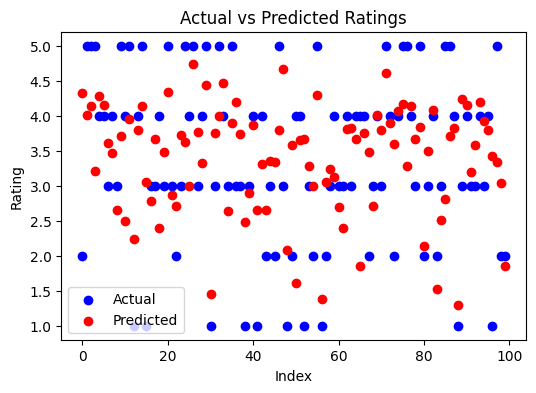

In [10]:
comparison = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
comparison_head = comparison.head(100).reset_index()
plt.figure(figsize=(6, 4))
plt.scatter(comparison_head.index, comparison_head['Actual'], color='blue', label='Actual')
plt.scatter(comparison_head.index, comparison_head['Predicted'], color='red', label='Predicted')
plt.xlabel('Index')
plt.ylabel('Rating')
plt.title('Actual vs Predicted Ratings')
plt.legend()
plt.show()
#结论修正，存在过拟合

In [11]:
#减轻模型复杂度（最佳表现）(loss下降的很好，但是比起GBDT还是差点意思，属于第二好的模型)
data1 = pd.read_csv('data1.csv')
data1.drop(data1.columns[0], axis=1, inplace=True)

class MovieRatingDataset(Dataset):
    def __init__(self, X_cat, X_genre, y):
        self.X_cat = torch.tensor(X_cat.values, dtype=torch.long)
        self.X_genre = torch.tensor(X_genre.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X_cat[idx], self.X_genre[idx], self.y[idx]

class WideAndDeepModel(nn.Module):
    def __init__(self, categorical_dims, embedding_dim, movie_genre_dim):
        super(WideAndDeepModel, self).__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(input_dim + 1, embedding_dim, padding_idx=0) for input_dim in categorical_dims
        ])
        self.genre_embedding = nn.Linear(movie_genre_dim, embedding_dim)
        self.deep = nn.Sequential(
            nn.Linear(len(categorical_dims) * embedding_dim + embedding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        self.wide = nn.Linear(len(categorical_dims) * embedding_dim + embedding_dim, 1)

    def forward(self, x_cat, x_genre):
        x_cat = [self.embeddings[i](x_cat[:, i].clamp(0, self.embeddings[i].num_embeddings - 1)) for i in range(len(self.embeddings))]
        x_cat = torch.cat(x_cat, dim=1)
        x_genre = self.genre_embedding(x_genre)
        x = torch.cat([x_cat, x_genre], dim=1)
        deep_out = self.deep(x)
        wide_out = self.wide(x)
        return wide_out + deep_out

def encode_features(train_df, test_df):
    encoded_train_df = train_df.copy()
    encoded_test_df = test_df.copy()
    label_encoders = {}
    
    for column in train_df.columns:
        le = LabelEncoder()
        le.fit(train_df[column])
        encoded_train_df[column] = le.transform(train_df[column])
        encoded_test_df[column] = test_df[column].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
        label_encoders[column] = le       
    return encoded_train_df, encoded_test_df, label_encoders

y = data1['rating']
X = data1.drop(columns=['rating'])

genre_cols = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
categorical_cols = X.drop(columns=genre_cols).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_cat, X_test_cat, label_encoders = encode_features(X_train[categorical_cols], X_test[categorical_cols])

X_train_genre = X_train[genre_cols]
X_test_genre = X_test[genre_cols]

train_dataset = MovieRatingDataset(X_train_cat, X_train_genre, y_train)
test_dataset = MovieRatingDataset(X_test_cat, X_test_genre, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

categorical_dims = [X_train[col].nunique() for col in categorical_cols]
model = WideAndDeepModel(categorical_dims, embedding_dim=4, movie_genre_dim=len(genre_cols))

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 43
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_cat_batch, X_genre_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_cat_batch, X_genre_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_cat_batch.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    if (epoch+1)%1==0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

model.eval()
y_pred = []
with torch.no_grad():
    for X_cat_batch, X_genre_batch, _ in test_loader:
        outputs = model(X_cat_batch, X_genre_batch).squeeze()
        y_pred.extend(outputs.numpy())
y_pred = np.array(y_pred)
mse = np.mean((y_test.values - y_pred) ** 2)
print(f'MSE: {mse:.4f}')

Epoch 1/43, Loss: 1.1765
Epoch 2/43, Loss: 0.9404
Epoch 3/43, Loss: 0.8968
Epoch 4/43, Loss: 0.8789
Epoch 5/43, Loss: 0.8639
Epoch 6/43, Loss: 0.8500
Epoch 7/43, Loss: 0.8391
Epoch 8/43, Loss: 0.8303
Epoch 9/43, Loss: 0.8219
Epoch 10/43, Loss: 0.8107
Epoch 11/43, Loss: 0.8037
Epoch 12/43, Loss: 0.7950
Epoch 13/43, Loss: 0.7856
Epoch 14/43, Loss: 0.7779
Epoch 15/43, Loss: 0.7723
Epoch 16/43, Loss: 0.7681
Epoch 17/43, Loss: 0.7562
Epoch 18/43, Loss: 0.7500
Epoch 19/43, Loss: 0.7469
Epoch 20/43, Loss: 0.7386
Epoch 21/43, Loss: 0.7343
Epoch 22/43, Loss: 0.7267
Epoch 23/43, Loss: 0.7246
Epoch 24/43, Loss: 0.7191
Epoch 25/43, Loss: 0.7161
Epoch 26/43, Loss: 0.7116
Epoch 27/43, Loss: 0.7100
Epoch 28/43, Loss: 0.7058
Epoch 29/43, Loss: 0.7029
Epoch 30/43, Loss: 0.6983
Epoch 31/43, Loss: 0.6964
Epoch 32/43, Loss: 0.6897
Epoch 33/43, Loss: 0.6880
Epoch 34/43, Loss: 0.6885
Epoch 35/43, Loss: 0.6824
Epoch 36/43, Loss: 0.6797
Epoch 37/43, Loss: 0.6784
Epoch 38/43, Loss: 0.6775
Epoch 39/43, Loss: 0.

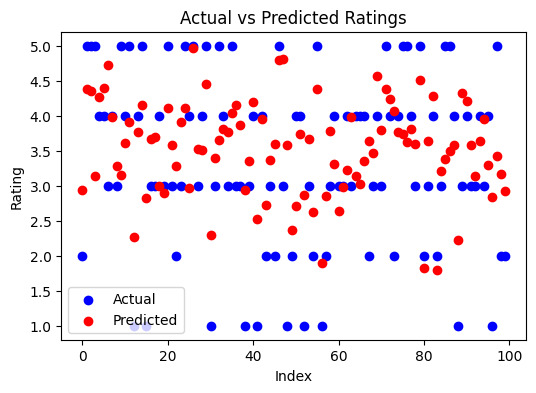

In [12]:
comparison = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
comparison_head = comparison.head(100).reset_index()
plt.figure(figsize=(6, 4))
plt.scatter(comparison_head.index, comparison_head['Actual'], color='blue', label='Actual')
plt.scatter(comparison_head.index, comparison_head['Predicted'], color='red', label='Predicted')
plt.xlabel('Index')
plt.ylabel('Rating')
plt.title('Actual vs Predicted Ratings')
plt.legend()
plt.show()

In [13]:
#有限的表达能力是存疑的
data1 = pd.read_csv('data1.csv')
data1.drop(data1.columns[0], axis=1, inplace=True)

class MovieRatingDataset(Dataset):
    def __init__(self, X_cat, X_genre, y):
        self.X_cat = torch.tensor(X_cat.values, dtype=torch.long)
        self.X_genre = torch.tensor(X_genre.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X_cat[idx], self.X_genre[idx], self.y[idx]

class WideAndDeepModel(nn.Module):
    def __init__(self, categorical_dims, embedding_dim, movie_genre_dim):
        super(WideAndDeepModel, self).__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(input_dim + 1, embedding_dim, padding_idx=0) for input_dim in categorical_dims
        ])
        self.genre_embedding = nn.Linear(movie_genre_dim, embedding_dim)
        self.deep = nn.Sequential(
            nn.Linear(len(categorical_dims) * embedding_dim + embedding_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
        self.wide = nn.Linear(len(categorical_dims) * embedding_dim + embedding_dim, 1)

    def forward(self, x_cat, x_genre):
        x_cat = [self.embeddings[i](x_cat[:, i].clamp(0, self.embeddings[i].num_embeddings - 1)) for i in range(len(self.embeddings))]
        x_cat = torch.cat(x_cat, dim=1)
        x_genre = self.genre_embedding(x_genre)
        x = torch.cat([x_cat, x_genre], dim=1)
        deep_out = self.deep(x)
        wide_out = self.wide(x)
        return wide_out + deep_out

def encode_features(train_df, test_df):
    encoded_train_df = train_df.copy()
    encoded_test_df = test_df.copy()
    label_encoders = {}
    
    for column in train_df.columns:
        le = LabelEncoder()
        le.fit(train_df[column])
        encoded_train_df[column] = le.transform(train_df[column])
        encoded_test_df[column] = test_df[column].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
        label_encoders[column] = le       
    return encoded_train_df, encoded_test_df, label_encoders

y = data1['rating']
X = data1.drop(columns=['rating'])

genre_cols = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
categorical_cols = X.drop(columns=genre_cols).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_cat, X_test_cat, label_encoders = encode_features(X_train[categorical_cols], X_test[categorical_cols])

X_train_genre = X_train[genre_cols]
X_test_genre = X_test[genre_cols]

train_dataset = MovieRatingDataset(X_train_cat, X_train_genre, y_train)
test_dataset = MovieRatingDataset(X_test_cat, X_test_genre, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

categorical_dims = [X_train[col].nunique() for col in categorical_cols]
model = WideAndDeepModel(categorical_dims, embedding_dim=4, movie_genre_dim=len(genre_cols))

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 43
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_cat_batch, X_genre_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_cat_batch, X_genre_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_cat_batch.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    if (epoch+1)%1==0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

model.eval()
y_pred = []
with torch.no_grad():
    for X_cat_batch, X_genre_batch, _ in test_loader:
        outputs = model(X_cat_batch, X_genre_batch).squeeze()
        y_pred.extend(outputs.numpy())
y_pred = np.array(y_pred)
mse = np.mean((y_test.values - y_pred) ** 2)
print(f'MSE: {mse:.4f}')

Epoch 1/43, Loss: 1.1996
Epoch 2/43, Loss: 0.9312
Epoch 3/43, Loss: 0.8903
Epoch 4/43, Loss: 0.8757
Epoch 5/43, Loss: 0.8629
Epoch 6/43, Loss: 0.8529
Epoch 7/43, Loss: 0.8433
Epoch 8/43, Loss: 0.8348
Epoch 9/43, Loss: 0.8270
Epoch 10/43, Loss: 0.8185
Epoch 11/43, Loss: 0.8107
Epoch 12/43, Loss: 0.8010
Epoch 13/43, Loss: 0.7955
Epoch 14/43, Loss: 0.7879
Epoch 15/43, Loss: 0.7800
Epoch 16/43, Loss: 0.7755
Epoch 17/43, Loss: 0.7675
Epoch 18/43, Loss: 0.7608
Epoch 19/43, Loss: 0.7553
Epoch 20/43, Loss: 0.7521
Epoch 21/43, Loss: 0.7465
Epoch 22/43, Loss: 0.7391
Epoch 23/43, Loss: 0.7380
Epoch 24/43, Loss: 0.7376
Epoch 25/43, Loss: 0.7311
Epoch 26/43, Loss: 0.7306
Epoch 27/43, Loss: 0.7259
Epoch 28/43, Loss: 0.7230
Epoch 29/43, Loss: 0.7197
Epoch 30/43, Loss: 0.7182
Epoch 31/43, Loss: 0.7163
Epoch 32/43, Loss: 0.7128
Epoch 33/43, Loss: 0.7078
Epoch 34/43, Loss: 0.7077
Epoch 35/43, Loss: 0.7060
Epoch 36/43, Loss: 0.7037
Epoch 37/43, Loss: 0.7015
Epoch 38/43, Loss: 0.7009
Epoch 39/43, Loss: 0.